### References:
 -    https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/
![title](img/ROC.png)
![title](img/ConfusionMatrix.png)

In [121]:
import pandas as pd
import numpy as np
from scipy.stats import mode
from scipy import interp
import itertools


import matplotlib.pyplot as plt 
plt.rc("font", size=14)

from sklearn import preprocessing, linear_model, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline, FeatureUnion


%matplotlib inline

In [119]:
# Function to count the number of missing rows
def num_missing(x):
  return sum(x.isnull())

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Example Data Set (UCI-opensource):
- https://archive.ics.uci.edu/ml/index.php

In [89]:
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/bank-additional.csv'
df_bank = pd.read_csv(url, sep=';')
df_bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


# Missing values?
 - view
 - create some to practice imputing

In [90]:
# First we look at the columns for missing data
print(df_bank.isna().sum())
print();

# Simulate some drop outs
remove_n = 10
drop_indices = np.random.choice(df_bank.index, remove_n, replace=False)
df_bank.loc[drop_indices, ["job", "marital", "duration"]] = [np.nan, np.nan, np.nan]
print(df_bank.isna().sum())
print();

# Use fillna to impute the missing values by the most frequent category label or float(duration)
df_bank['job'].fillna(df_bank['job'].value_counts().idxmax(), inplace=True)
df_bank['marital'].fillna(df_bank['marital'].value_counts().idxmax(), inplace=True)
df_bank['duration'].fillna(mode(df_bank['duration']).mode[0], inplace=True)
print(df_bank.isna().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

age                0
job               10
marital           10
education          0
default            0
housing            0
loan               0
contact            0
month              0
day_of_week        0
duration          10
campaign           0
pdays              0
previous           0
poutcome           0
emp.var.rate       0
cons.price.idx     0
cons.conf.idx      0
euribor3m          0
nr.employed        0
y                  0
dtype: int64

age               0
job               0
marital           0
education         0
default           0
housing    

In [91]:
df_bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [92]:
cols=['previous', 'euribor3m', "poutcome", "job", 'month'] 
X=df_bank[cols]
Y=df_bank['y']

display(X.head(10))

,previous,euribor3m,poutcome,job,month
0,0,1.313,nonexistent,blue-collar,may
1,0,4.855,nonexistent,services,may
2,0,4.962,nonexistent,services,jun
3,0,4.959,nonexistent,services,jun
4,0,4.191,nonexistent,admin.,nov
5,2,0.884,failure,services,sep
6,0,0.879,nonexistent,admin.,sep
7,0,4.191,nonexistent,entrepreneur,nov
8,1,4.153,failure,services,nov
9,0,4.855,nonexistent,blue-collar,may


In [93]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

# create X (including 13 dummy columns)
feature_cols = ['default', 'contact', 'euribor3m', 'previous', "poutcome", "job", 'month'] 

X = df_bank[feature_cols]
lb_contact = LabelBinarizer()
lb_default = LabelBinarizer()
lb_poutcome = LabelBinarizer()
lb_month = LabelBinarizer()
lb_job = LabelBinarizer()
X['contact'] = pd.DataFrame(lb_contact.fit_transform(df_bank["contact"].values).reshape(len(df_bank["contact"]),-1))
X['default'] = pd.DataFrame(lb_default.fit_transform(df_bank["default"].values).reshape(len(df_bank["default"]),-1))
X['poutcome'] = pd.DataFrame(lb_poutcome.fit_transform(df_bank["poutcome"].values).reshape(len(df_bank["poutcome"]),-1))
X['month'] = pd.DataFrame(lb_month.fit_transform(df_bank["month"].values).reshape(len(df_bank["month"]),-1))
X['job'] = pd.DataFrame(lb_job.fit_transform(df_bank["job"].values).reshape(len(df_bank["job"]),-1))

# create y
lb_y = LabelBinarizer()
df_bank["outcomes"] = pd.DataFrame(lb_y.fit_transform(df_bank["y"].values).reshape(len(df_bank["y"]),-1))
Y = df_bank["outcomes"]

# calculate cross-validated AUC

logreg = LogisticRegression(C=1e9)
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

0.7543163845879903

In [94]:
clf1 = linear_model.LogisticRegression(penalty='l2', C=0.1)
clf1.fit(X_train, Y_train)
probs = clf1.predict_proba(X_test)

predicted = clf1.predict(X_test)

prob=probs[:,1]
prob_df=pd.DataFrame(prob)
prob_df['predict']=np.where(prob_df[0]>=0.10,1,0)
display(prob_df.head())
print(metrics.accuracy_score(Y_test, predicted))

,0,predict
0,0.026788,0
1,0.149983,1
2,0.039494,0
3,0.035810,0
4,0.070878,0


0.9004854368932039


In [113]:
X.iloc[train]

,default,contact,euribor3m,previous,poutcome,job,month
688,1,1,4.857,0,0,0,0
689,1,0,0.904,0,0,0,0
690,1,0,4.962,0,0,0,0
691,1,1,4.963,0,0,0,0
692,1,1,4.856,0,0,0,0
693,1,0,1.260,0,0,0,0
694,1,0,4.120,1,1,0,0
695,1,0,0.886,2,1,1,0
696,0,0,0.877,4,0,0,0
697,1,0,4.963,0,0,1,0


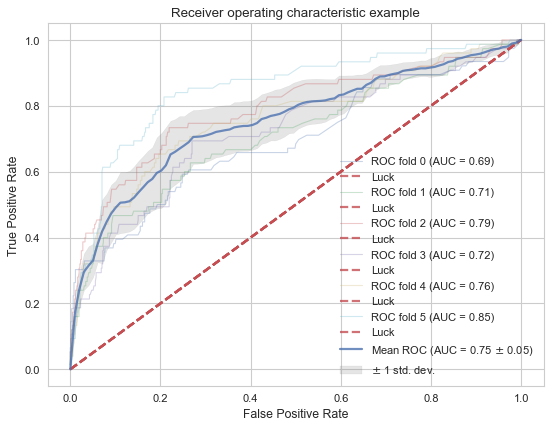

          Confusion Matrix -- Full Set:

Confusion matrix, without normalization
Normalized confusion matrix


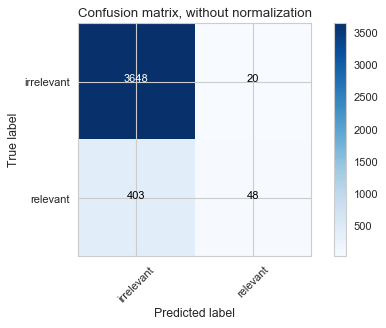

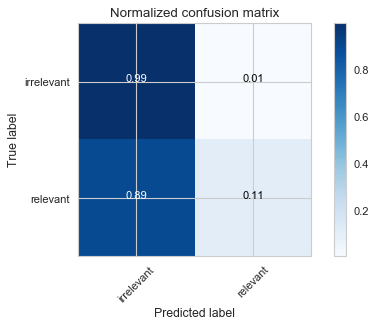

             precision    recall  f1-score   support

          0       0.90      0.99      0.95      3668
          1       0.71      0.11      0.18       451

avg / total       0.88      0.90      0.86      4119



<function print>

In [126]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
plt.figure(num=1, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

pipeline = Pipeline([
    ('clf', LogisticRegression(C=7.9432823472428051)),
])

for train, test in cv.split(X, Y):
    probas_ = pipeline.fit(X.iloc[train], Y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y.iloc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
              label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig("ROC.png")
plt.show()

# Display the confusion matrix
# Recall (X_,Y_) is the full training set comments(X_)and target labels (Y_)
#
Yp_ = pipeline.predict(X)
my_metrics = metrics.classification_report(Y, Yp_)
print("          Confusion Matrix -- Full Set:")
print()
cnf_matrix = metrics.confusion_matrix(Y, Yp_)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(num=2, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes=['irrelevant', 'relevant'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(num=3, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes=['irrelevant', 'relevant'], normalize=True,
                      title='Normalized confusion matrix')
plt.savefig("ConfusionMatrix.png")
plt.show()

print
print
my_metrics = metrics.classification_report(Y, Yp_)
print(my_metrics)
print
print
